In [1]:
import cv2
from scipy.fftpack import dct, idct
from PIL import Image,ImageDraw  # necessari tenir instalar llibreria PILLOW
import numpy as np
import metrikz
import time
import matplotlib.pyplot as plt


quantization_matrix =  [[16.,11.,10.,16.,24.,40.,51.,61.],
                        [12.,12.,14.,19.,26.,58.,60.,55.],
                        [14.,13.,16.,24.,40.,57.,69.,56.],
                        [14.,17.,22.,29.,51.,87.,80.,62.],
                        [18.,22.,37.,56.,68.,109.,103.,77.],
                        [24.,35.,55.,64.,81.,104.,113.,92.],
                        [49.,64.,78.,87.,103.,121.,120.,101.],
                        [72.,92.,95.,98.,112.,100.,103.,99.]]




In [41]:

def dct2(block):
    return dct(dct(block, axis=0, norm = 'ortho'), axis=1, norm = 'ortho'); 
                   



def idct2(block):
    return idct(idct(block, axis=1, norm = 'ortho'), axis=0, norm = 'ortho');
    
    
    

def quantization_process(block):
    qm=np.zeros((8, 8))
    for i in range(int(len(block))):
        for j in range(int(len(block))):
            qm[i][j] = np.round( float(block[i][j]) / quantization_matrix[i][j])
    return qm
    
    

# Aplicar DCT y llamar la funcion de cuantizacion pel vector dels errors.
def func_quantized(block):
    qm=np.zeros((8, 8),dtype=int)  
    qm[:,:] = quantization_process(dct2(block[:,:]))
    return qm


# El inverso de la operacion anterior
def func_inverse(block):
    inverse=idct2(block * quantization_matrix)
    for i in range(int(len(inverse))):
        for j in range(int(len(inverse))):
            inverse[i][j] = np.round(inverse[i][j])
    return inverse




# Exercici 1

In [3]:
#frame anterior
I1 = Image.open("frame0_1.png")
#frame actual
I2 = Image.open("frame0_2.png")

#   I1.show()
img1 = I1.convert('L')
img1.save('frame1_gray.png')
img2 = I2.convert('L')
img2.save('frame2_gray.png')
#   img1.show()
   
frame1 = cv2.imread("frame1_gray.png")
frame2 = cv2.imread("frame2_gray.png")
frame1=frame1[:,:,0]
frame2=frame2[:,:,0]
  
print("dimensions de la imatge =",frame1.shape  )
dim=frame1.shape
    
#vectors finals
actual_position=[]
motion_vector=[]
errors_prediction=[]
       
# matriu per generar els blocs 
bl=np.zeros((8, 8))

dimensions de la imatge = (16, 24)


In [4]:
def dividir_blocs(frame):
    #matriu per generar els blocs
    #vector per guardar els blocs
    blocs=[]

    for i in range(0, frame.shape[0] , 8):
        for j in range(0, frame.shape[1] , 8):
            blocs.append([i,j ])
    return blocs

## Apartat V1

In [38]:
import sys
def calcular_mseA(frame1, frame2, blocs):
    blocs_minims = []
    for bloc in blocs:
        minim_mse = sys.maxsize
        bloc_minim = [] 
        for positionj in range(0, frame2.shape[1] - 7):
            for positioni in range(0, frame2.shape[0] - 7):
                mse = metrikz.mse(frame1[bloc[0]:bloc[0]+8, bloc[1]:bloc[1]+8], frame2[positioni:positioni+8, positionj:positionj+8])
                if mse < minim_mse:
                    minim_mse = mse
                    bloc_minim = [positioni, positionj]
                    error_prediccio = func_quantized(frame1[bloc[0]:bloc[0]+8, bloc[1]:bloc[1]+8] - frame2[positioni:positioni+8, positionj:positionj+8])
                    
        blocs_minims.append(([bloc[0], bloc[1]],bloc_minim, minim_mse, error_prediccio))
    return blocs_minims

In [6]:
mseA = calcular_mseA(frame1, frame2, dividir_blocs(frame1))

In [7]:
mseA

[([0, 0], [0, 0], 0.0),
 ([0, 8], [8, 0], 0.0),
 ([0, 16], [0, 16], 0.0),
 ([8, 0], [0, 8], 2002.5625),
 ([8, 8], [8, 8], 0.0),
 ([8, 16], [8, 16], 0.0)]

## Apartat V2

In [39]:
def calcular_mseB(frame1, frame2, blocs):
    blocs_minims = []
    for bloc in blocs:
        minim_mse = sys.maxsize
        bloc_minim = []
        i = 0
        for positioni in range(bloc[0] - 8 , bloc[0] + 9):
            if positioni < 0 or positioni > frame2.shape[0] - 8:
                continue
            for positionj in range(bloc[1] -8 , bloc[1]  + 9):
                if positionj < 0 or positionj > frame2.shape[1] - 8:
                    continue
                mse = metrikz.mse(frame1[bloc[0]:bloc[0]+8, bloc[1]:bloc[1]+8], frame2[positioni:positioni+8, positionj:positionj+8])
                i = i + 1
                if mse < minim_mse:
                    minim_mse = mse
                    bloc_minim = [positioni, positionj]
                    error_prediccio = func_quantized(frame1[bloc[0]:bloc[0]+8, bloc[1]:bloc[1]+8] - frame2[positioni:positioni+8, positionj:positionj+8])
        blocs_minims.append(([bloc[0], bloc[1]],bloc_minim, minim_mse, error_prediccio))
    return blocs_minims

In [9]:
mseB = calcular_mseB(frame1, frame2, dividir_blocs(frame1))

In [10]:
mseB

[([0, 0], [0, 0], 0.0),
 ([0, 8], [8, 0], 0.0),
 ([0, 16], [0, 16], 0.0),
 ([8, 0], [0, 8], 2002.5625),
 ([8, 8], [8, 8], 0.0),
 ([8, 16], [8, 16], 0.0)]

# Exercici 2

In [11]:
import os
import glob

patron = "*frame*"
archivos = glob.glob(f"{patron}")
cantidad_archivos = len(archivos)/2

dades = []

for i in range(0, int(cantidad_archivos) + 1):
    nombre_archivo = f"frame{i}_{1}.png"
    if os.path.isfile(os.path.join('./', nombre_archivo)):
        print(f"Existe el archivo {nombre_archivo}")
        nombre_archivo = f"frame{i}_{2}.png"
        if os.path.isfile(os.path.join('./', nombre_archivo)):
            print(f"Existe el archivo {nombre_archivo}")
        frame1 = cv2.cvtColor(cv2.imread(f"frame{i}_{1}.png"), cv2.COLOR_BGR2GRAY)
        frame2 = cv2.cvtColor(cv2.imread(f"frame{i}_{2}.png"), cv2.COLOR_BGR2GRAY)
        timeA = time.time()
        mseA = calcular_mseA(frame1, frame2, dividir_blocs(frame1))
        timeA = time.time() - timeA
        timeB = time.time()
        mseB = calcular_mseB(frame1, frame2, dividir_blocs(frame1))
        timeB = time.time() - timeB
        dades.append([i,(mseA, mseB), timeA, timeB])
        



Existe el archivo frame0_1.png
Existe el archivo frame0_2.png
Existe el archivo frame1_1.png
Existe el archivo frame1_2.png


Existe el archivo frame2_1.png
Existe el archivo frame2_2.png


KeyboardInterrupt: 

In [ ]:
for i in dades:
    print(f"Frame {i[0]}")
    print(f"Temps A: {i[2]}")
    print(f'mseA: {i[1][0]}')
    print(f"Temps B: {i[3]}")
    print(f'mseB:  {i[1][1]}')
    print("------------------------------------------------------------------------------------------------------------")

Frame 0
Temps A: 0.022869110107421875
mseA: [([0, 0], [0, 0], 0.0), ([0, 8], [8, 0], 0.0), ([0, 16], [0, 16], 0.0), ([8, 0], [0, 8], 2002.5625), ([8, 8], [8, 8], 0.0), ([8, 16], [8, 16], 0.0)]
Temps B: 0.013854026794433594
mseB:  [([0, 0], [0, 0], 0.0), ([0, 8], [8, 0], 0.0), ([0, 16], [0, 16], 0.0), ([8, 0], [0, 8], 2002.5625), ([8, 8], [8, 8], 0.0), ([8, 16], [8, 16], 0.0)]
------------------------------------------------------------------------------------------------------------
Frame 1
Temps A: 138.71679306030273
mseA: [([0, 0], [53, 0], 360.375), ([0, 8], [1, 22], 86.625), ([0, 16], [1, 30], 2.28125), ([0, 24], [1, 38], 92.640625), ([0, 32], [0, 46], 1008.828125), ([0, 40], [0, 54], 17.359375), ([0, 48], [0, 62], 54.53125), ([0, 56], [0, 69], 288.6875), ([0, 64], [1, 78], 14.0625), ([0, 72], [0, 85], 83.890625), ([0, 80], [0, 93], 381.234375), ([0, 88], [0, 101], 61.078125), ([0, 96], [0, 109], 120.8125), ([0, 104], [0, 117], 282.359375), ([0, 112], [0, 126], 181.25), ([0, 120], 

# Exercici 3

In [50]:
# Funció per crear l'algoritme de motion compensation. DECODIFICADOR
def func_motion_compensation(actual_position, motion_vector):

    ## 
    ## Implementar motion compensation.
    ## Crear frame3 a partir de frame1 i MV
    print("Actual position shape: ", actual_position.shape)
    l3 = np.zeros(actual_position.shape)
    print("l3.shape: ", l3.shape)
    for bloc in motion_vector:
        print("Posicio l3: [", bloc[1][0], ":", bloc[1][0]+8, "][", bloc[1][1], ":", bloc[1][1]+8, "]")
        print("Posicio actual_position: [", bloc[0][0], ":", bloc[0][0]+8, "][", bloc[0][1], ":", bloc[0][1]+8, "]")
        l3[bloc[1][0]:(bloc[1][0]+8), bloc[1][1]:(bloc[1][1]+8)] = actual_position[bloc[0][0]:(bloc[0][0]+8), bloc[0][1]:(bloc[0][1]+8)]
    img1.save('l3_frame0.png')
    ## i despres crear frame4 i corregir amb errors de prediccio
    l4 = l3
    for bloc in motion_vector:
        error_prediccio = bloc[3]
        print("error de prediccio.shape: ", error_prediccio.shape)
        error_descomprimit = func_inverse(error_prediccio)
        print("error descomprimit.shape: ", error_descomprimit.shape)
        l4[bloc[1][0]:(bloc[1][0]+8), bloc[1][1]:(bloc[1][1]+8)] = l4[bloc[1][0]:(bloc[1][0]+8), bloc[1][1]:(bloc[1][1]+8)] + error_descomprimit
    ## tenint en compte que estan en el format adient de la matriu d'errors.
    ## (aplicar procés invers de la sessió 2 amb els errors de predicció.
    ##

    diferencia1 = cv2.absdiff(l3.astype(int), actual_position.astype(int))
    diferencia2 = cv2.absdiff(l4.astype(int), actual_position.astype(int))

    # Visualizar el mapa de calor de la diferencia
    plt.imshow(diferencia1, cmap='hot', interpolation='nearest')
    plt.colorbar()
    plt.title('Mapa de calor de diferencia entre l3 i l2')
    plt.show()

    plt.imshow(diferencia2, cmap='hot', interpolation='nearest')
    plt.colorbar()
    plt.title('Mapa de calor de diferencia entre l4 i l2')
    plt.show()

    mse1 = metrikz.mse(l3, actual_position)
    mse2 = metrikz.mse(l4, actual_position)

    print("MSE entre l3 i l2: ", mse1)
    print("MSE entre l4 i l2: ", mse2)

Actual position shape:  (16, 24)
l3.shape:  (16, 24)
Posicio l3: [ 0 : 8 ][ 0 : 8 ]
Posicio actual_position: [ 0 : 8 ][ 0 : 8 ]
Posicio l3: [ 8 : 16 ][ 0 : 8 ]
Posicio actual_position: [ 0 : 8 ][ 8 : 16 ]
Posicio l3: [ 0 : 8 ][ 16 : 24 ]
Posicio actual_position: [ 0 : 8 ][ 16 : 24 ]
Posicio l3: [ 0 : 8 ][ 8 : 16 ]
Posicio actual_position: [ 8 : 16 ][ 0 : 8 ]
Posicio l3: [ 8 : 16 ][ 8 : 16 ]
Posicio actual_position: [ 8 : 16 ][ 8 : 16 ]
Posicio l3: [ 8 : 16 ][ 16 : 24 ]
Posicio actual_position: [ 8 : 16 ][ 16 : 24 ]
error de prediccio.shape:  (8, 8)
error descomprimit.shape:  (8, 8)
error de prediccio.shape:  (8, 8)
error descomprimit.shape:  (8, 8)
error de prediccio.shape:  (8, 8)
error descomprimit.shape:  (8, 8)
error de prediccio.shape:  (8, 8)
error descomprimit.shape:  (8, 8)
error de prediccio.shape:  (8, 8)
error descomprimit.shape:  (8, 8)
error de prediccio.shape:  (8, 8)
error descomprimit.shape:  (8, 8)


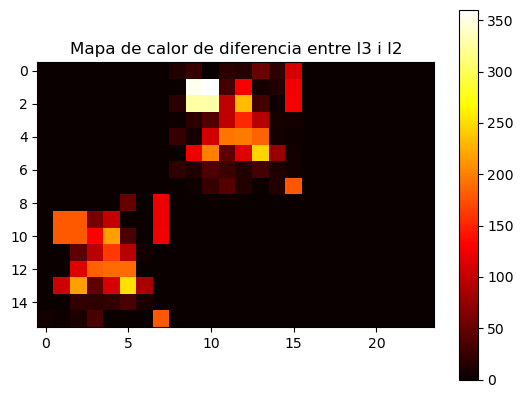

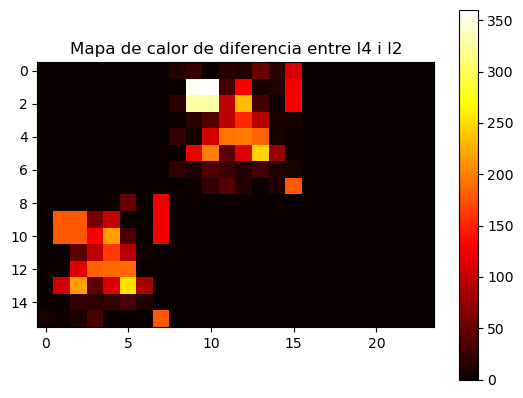

MSE entre l3 i l2:  4012.9401041666665
MSE entre l4 i l2:  4012.9401041666665


In [51]:
'''
for i in range(0, int(cantidad_archivos) + 1):
    nombre_archivo = f"frame{i}_{1}.png"
    if os.path.isfile(os.path.join('./', nombre_archivo)):
        print(f"Existe el archivo {nombre_archivo}")
        nombre_archivo = f"frame{i}_{2}.png"
        if os.path.isfile(os.path.join('./', nombre_archivo)):
            print(f"Existe el archivo {nombre_archivo}")
        frame1 = cv2.cvtColor(cv2.imread(f"frame{i}_{1}.png"), cv2.COLOR_BGR2GRAY)
        frame2 = cv2.cvtColor(cv2.imread(f"frame{i}_{2}.png"), cv2.COLOR_BGR2GRAY)
        mseA = calcular_mseA(frame1, frame2, dividir_blocs(frame1))
        mseB = calcular_mseB(frame1, frame2, dividir_blocs(frame1))
        print("//////////////////////////////////////////////////////////////")
        print("Resultats algorisme V1:")
        func_motion_compensation(frame2, mseA)
        print("//////////////////////////////////////////////////////////////")
        print("Resultats algorisme V2:")
        func_motion_compensation(frame2, mseB)
'''

frame1 = cv2.imread("frame1_gray.png")
frame2 = cv2.imread("frame2_gray.png")
frame1=frame1[:,:,0]
frame2=frame2[:,:,0]
mseA = calcular_mseA(frame1, frame2, dividir_blocs(frame1))
func_motion_compensation(frame2, mseA)